In [1]:
# Stage 1: Collect Explore
# Stage 2: Annotate and convert labelme annotations to seg
# Stage 3: Find spawn location and target for reexplore (reexplore_data.json)
# Stage 4: Run reexplore for all objects, one at a time 
# Stage 5: Run label prop
# Stage 6: Run training 

In [8]:
# Stage 1: Collect Explore to $HOME/explore_data

# Stage 3: Find spawn location and target for reexplore (reexplore_data.json) in a separate out_dir
import os
explore_data = f"{os.environ['HOME']}/explore_data"
print(explore_data)

/home/locobotm/explore_data


obj_dir /home/locobotm/explore_data/default/0/reexplore/0
saving propagated frames to /home/locobotm/explore_data/default/0/reexplore/0/c1pp/pred
saving propagated frames to /home/locobotm/explore_data/default/0/reexplore/0/s1pp/pred


/tmp/ipykernel_2702/4129740480.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12 ,8))


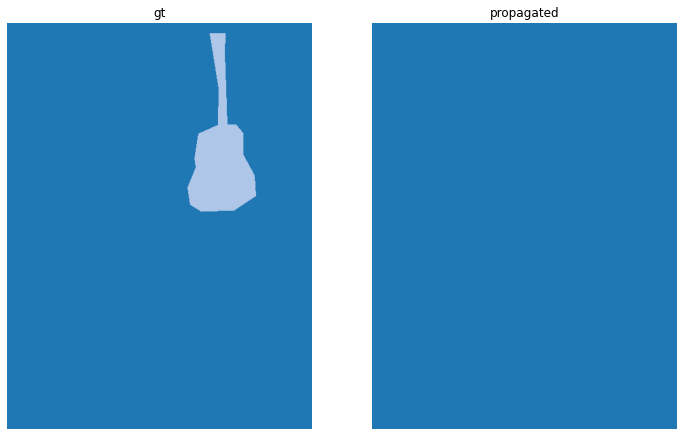

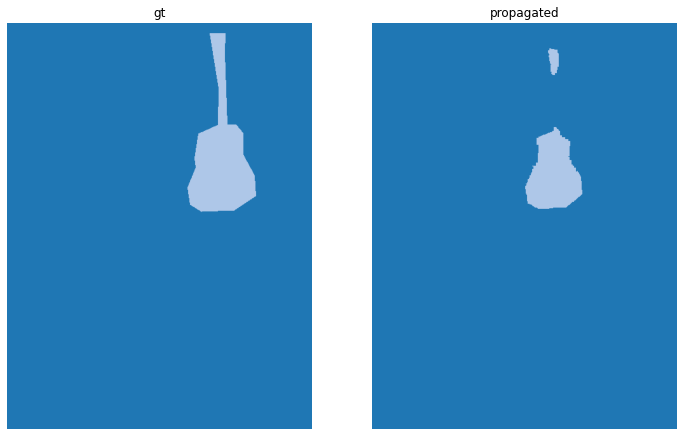

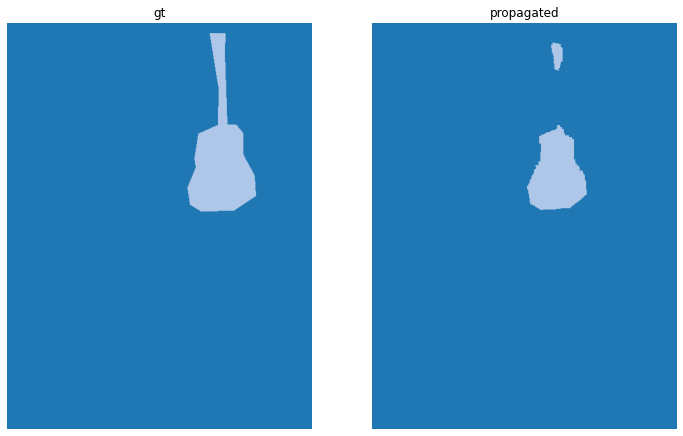

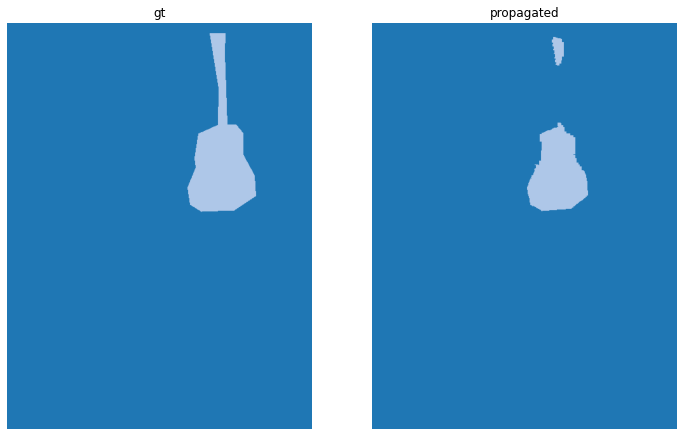

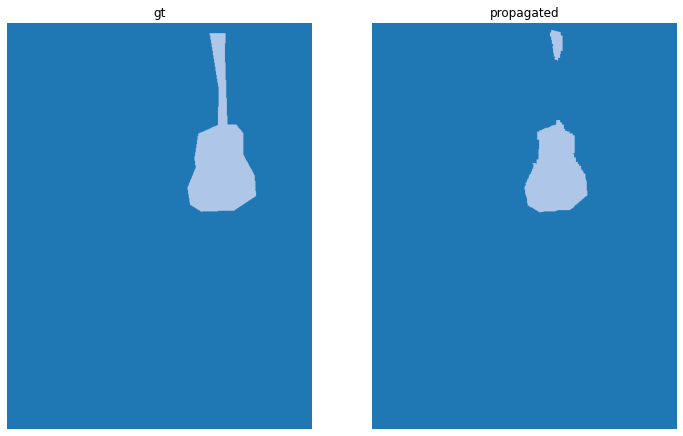

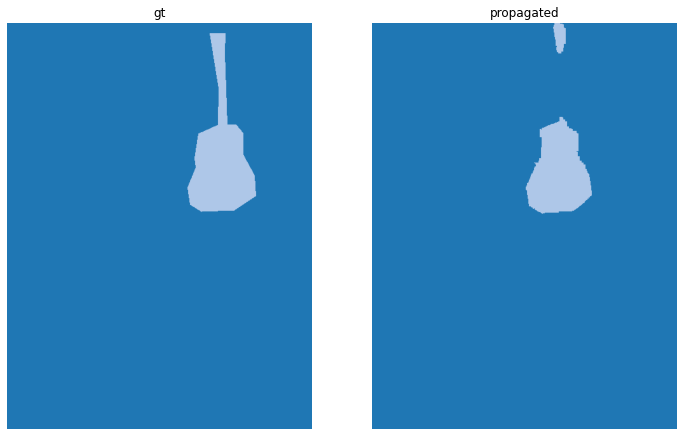

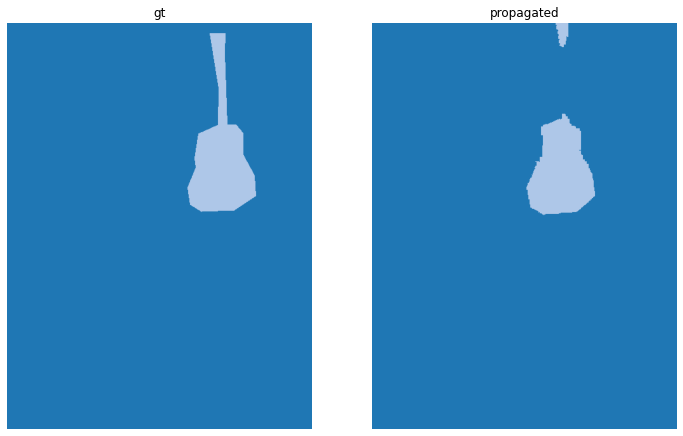

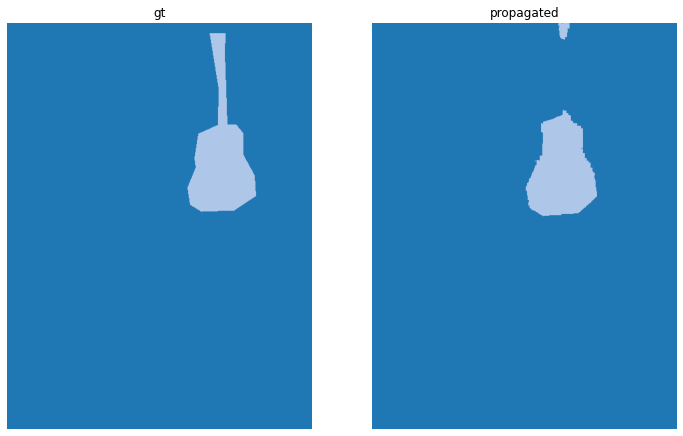

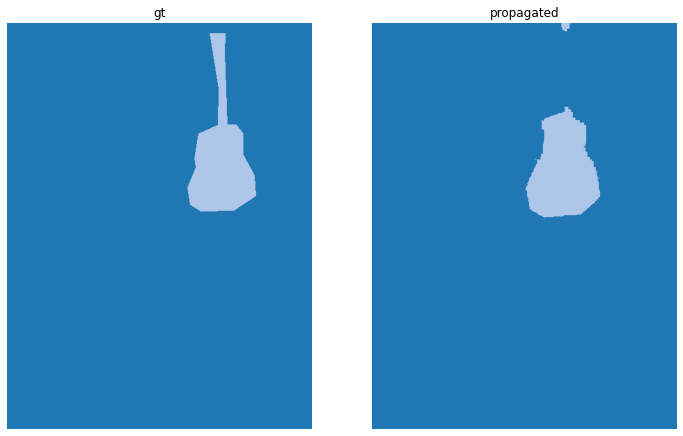

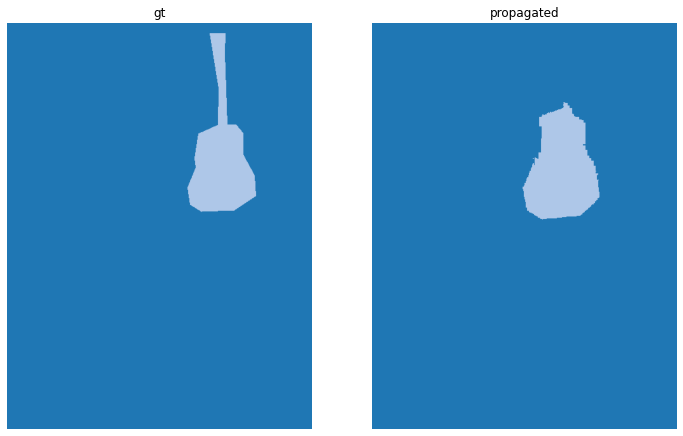

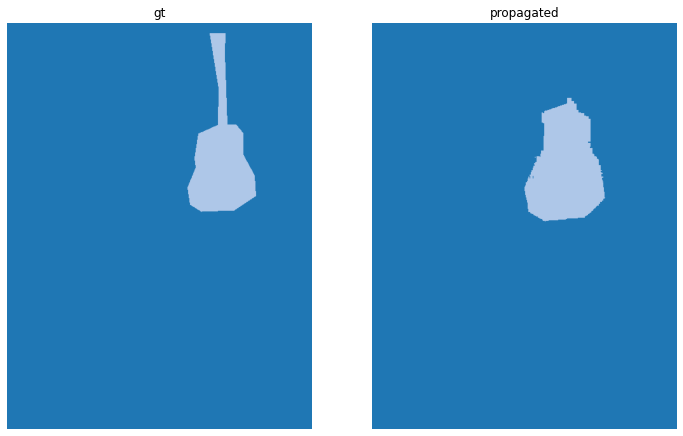

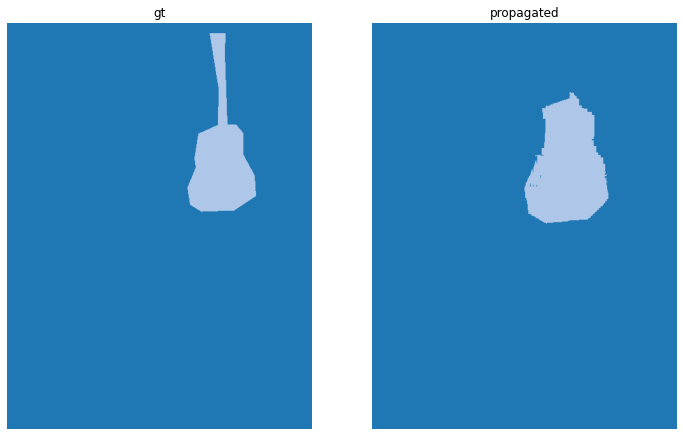

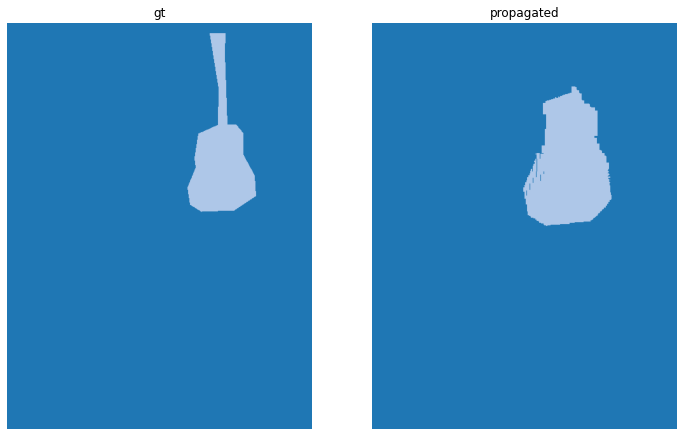

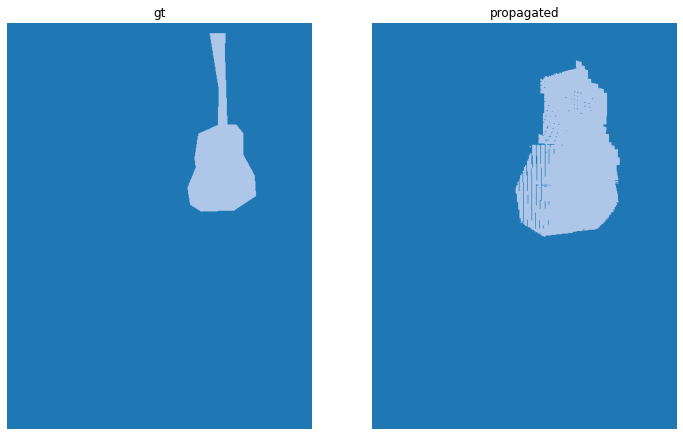

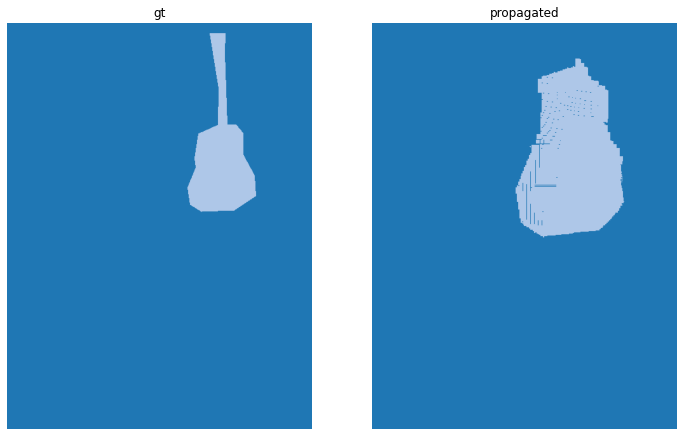

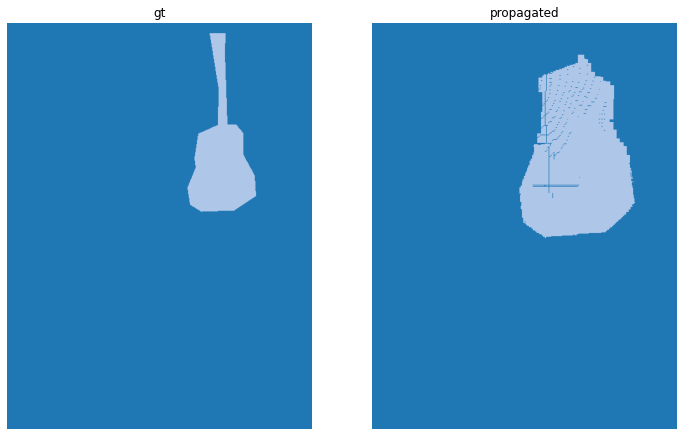

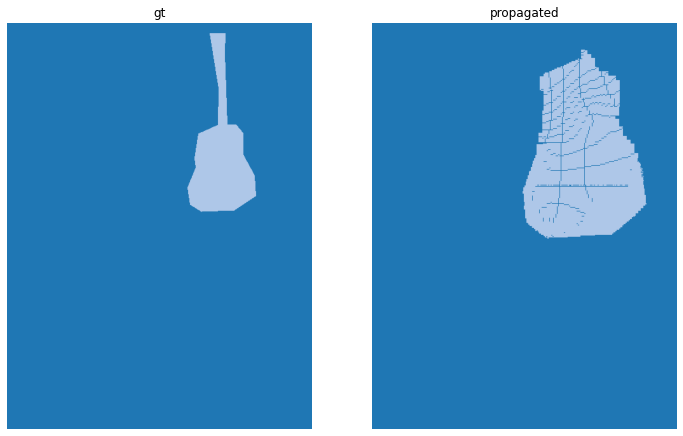

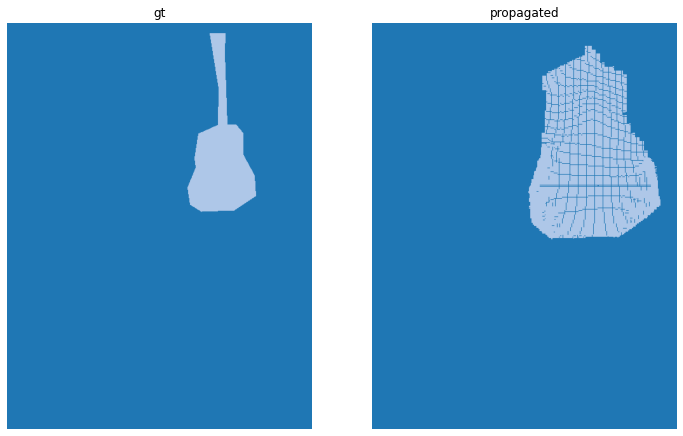

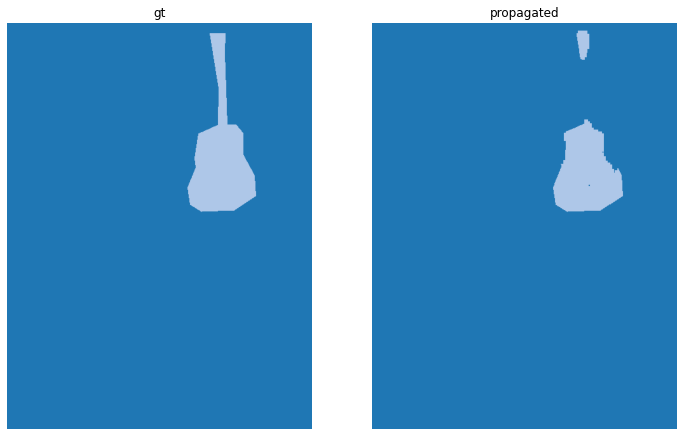

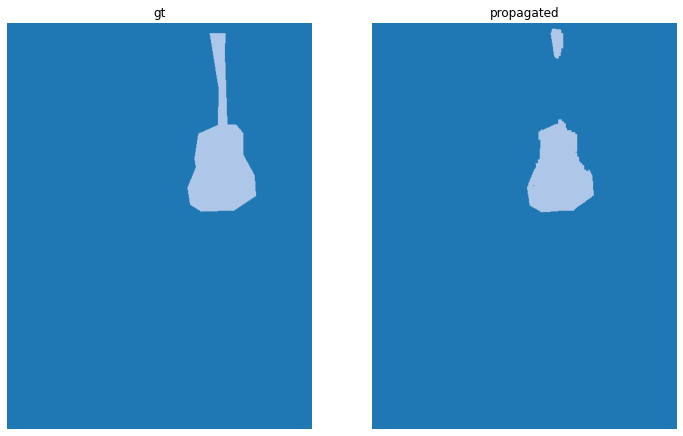

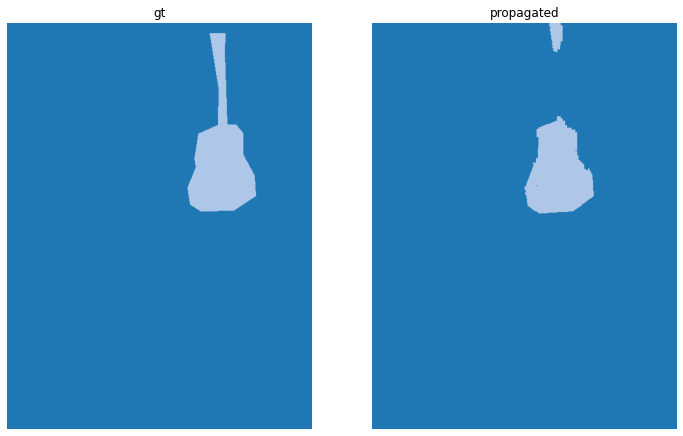

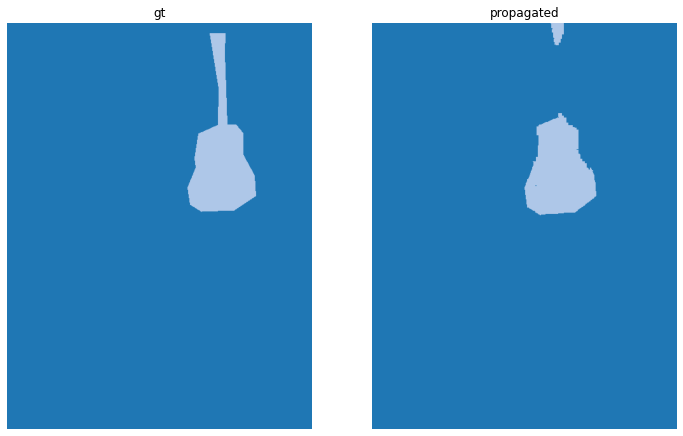

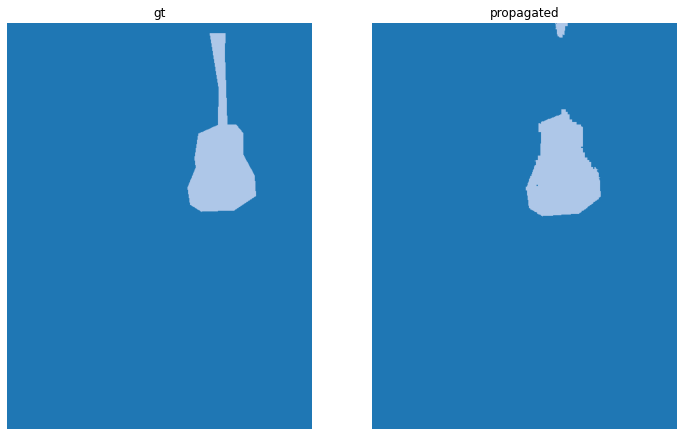

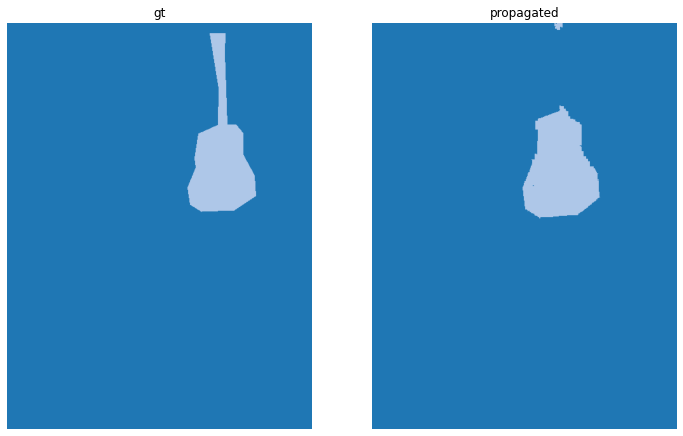

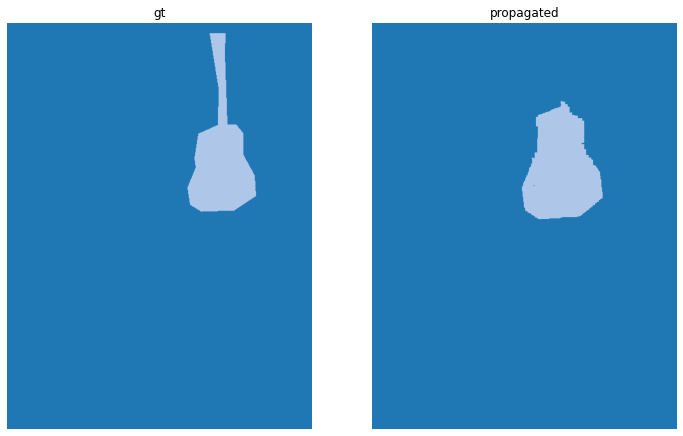

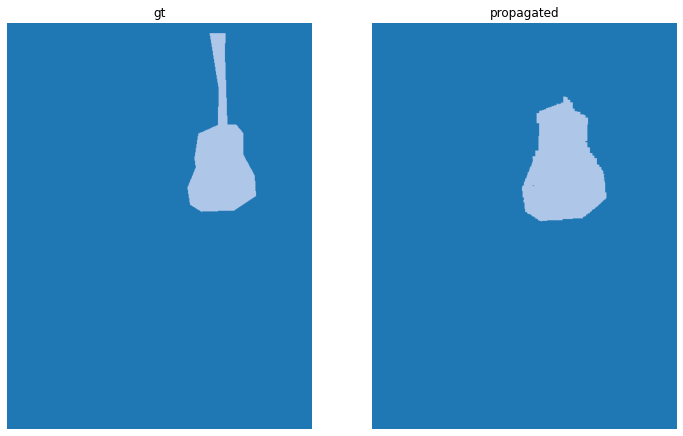

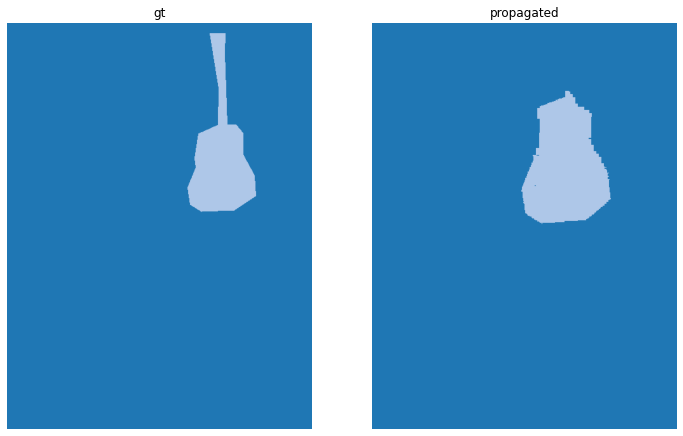

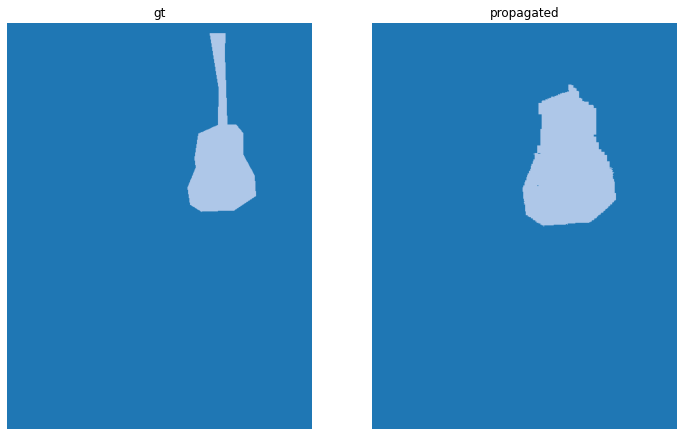

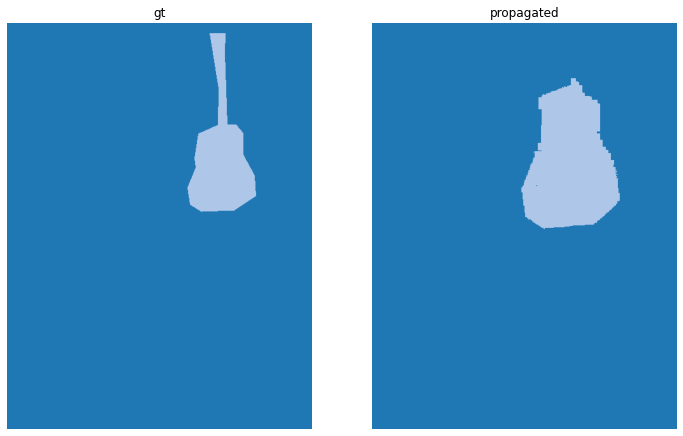

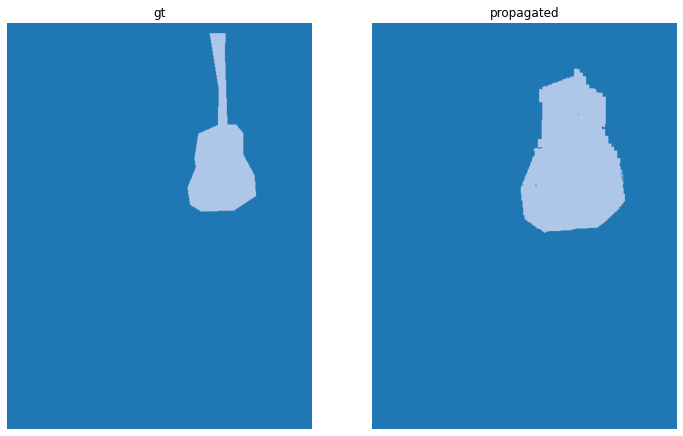

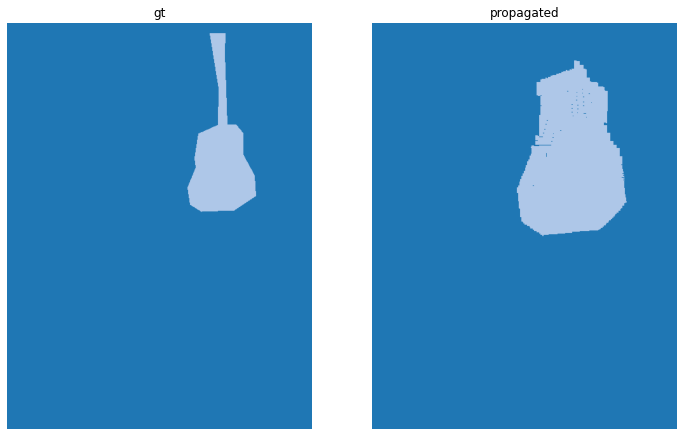

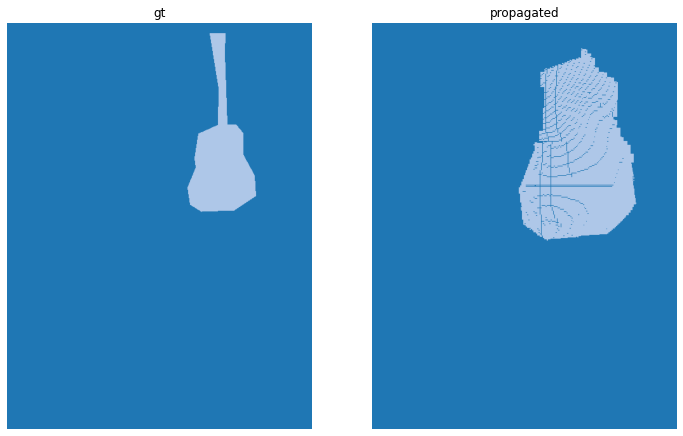

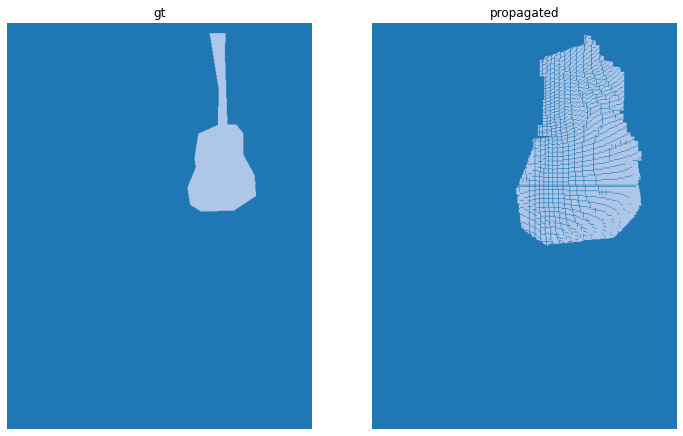

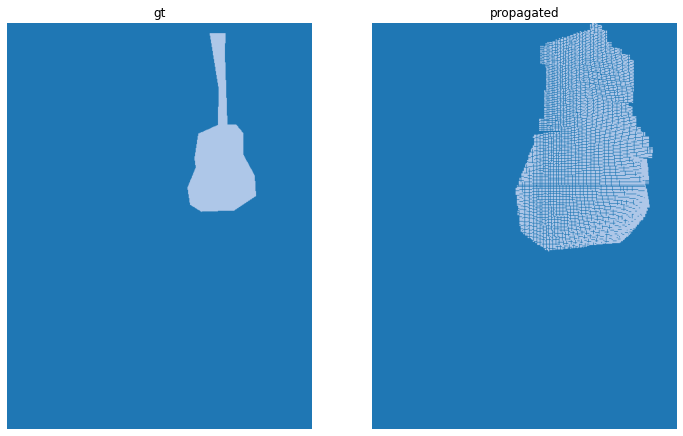

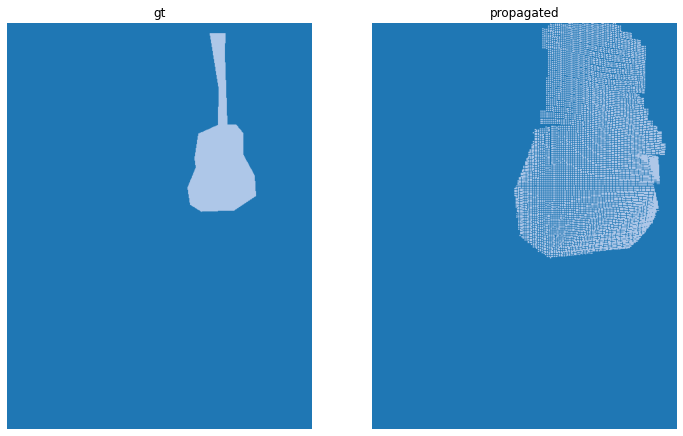

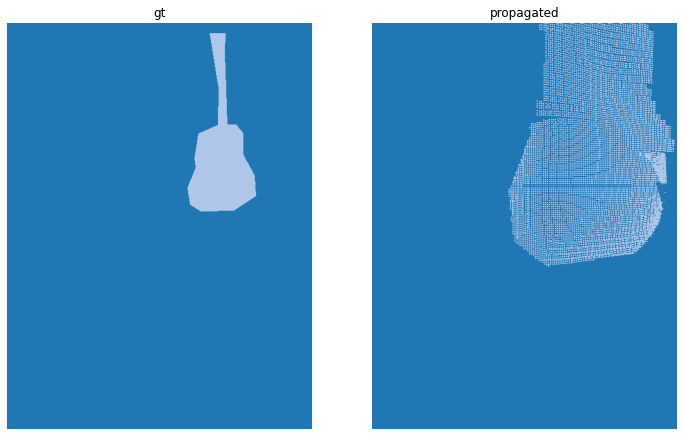

In [26]:
# Stage 5: Run label prop
# Ensure reex_dir has all objects reexplored

reex_dir = '/home/locobotm/explore_data/default/0/reexplore/'
explore_dir = '/home/locobotm/explore_data/default/0/'

# load reex json
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from droidlet.perception.robot import LabelPropagate
from run_label_prop import d3_40_colors_rgb
from PIL import Image

def save_propagated_visual(semantic1, semantic2, save_dir, out_indx):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    arr = []
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['gt', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.savefig("{}/{:05d}.jpg".format(save_dir, out_indx))


reex_json = os.path.join(reex_dir, 'reexplore_data.json')
with open(reex_json, 'r') as f:
    reex_data = json.load(f)

lp = LabelPropagate()
    
for reex_id in reex_data.keys():
    obj_dir = os.path.join(reex_dir, reex_id)
    obj_data = reex_data[reex_id]
    print(f'obj_dir {obj_dir}')
    src_img_indx = obj_data['src_img_id']
    # for each examine heuristic
    
    # load src_img_id rgb, label and pose
    src_img = cv2.imread(os.path.join(explore_dir, "rgb/{:05d}.jpg".format(src_img_indx)))
    src_depth = np.load(os.path.join(explore_dir, "depth/{:05d}.npy".format(src_img_indx)))
    src_label = np.load(os.path.join(explore_dir, "seg/{:05d}.npy".format(src_img_indx)))
    
    with open(os.path.join(explore_dir, 'data.json'), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(src_img_indx)]
    
    # for each heuristic, for each image in rgb, propagate 
    for heu in ['c1pp', 's1pp']:
        heu_dir = os.path.join(obj_dir, heu)
        prop_dir = os.path.join(heu_dir, 'pred')
        print(f'saving propagated frames to {prop_dir}')
        os.makedirs(prop_dir, exist_ok=True)

        num_samples = min(len(os.listdir(os.path.join(heu_dir, 'rgb'))), 18)
        with open(os.path.join(heu_dir, 'data.json'), "r") as f:
            cur_pose_data = json.load(f) 

        for p in range(num_samples):
            cur_pose = cur_pose_data[str(p)]
            cur_depth = np.load(os.path.join(heu_dir, "depth/{:05d}.npy".format(p)))

            annot_img = lp(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

            np.save(os.path.join(prop_dir, "{:05d}.npy".format(p)), annot_img.astype(np.uint32))
            save_propagated_visual(src_label, annot_img, os.path.join(prop_dir, 'lp_visuals'), p)
            
         #FIXME: also save the gt label

        
# TODO: combine all label prop for all objects in range(0,18,2) pred folders
# TODO: run coco and training on each pred folder
    